In [3]:
import sys
!{sys.executable} -m pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 19.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]


ขั้นที่ 1: กำลังโหลดข้อมูล...
ขั้นที่ 2: กำลังเตรียมข้อมูล...
เตรียมข้อมูลสำเร็จ
        date  district_code  rainfall_mm  season
0 2024-01-01           1001          8.0  Winter
1 2024-01-01           1033          0.0  Winter
2 2024-01-01           1018          0.0  Winter
3 2024-01-01           1046          0.0  Winter
4 2024-01-01           1043          0.0  Winter
--------------------------------------------------
ขั้นที่ 3: เลือก 1 เขต (จาก Cluster 0) มาสร้างโมเดลตัวอย่าง...
ได้ข้อมูล Time-Series ของเขต 1046 มา 347 วัน


/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3636 (\N{THAI CHARACTER SARA I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI C

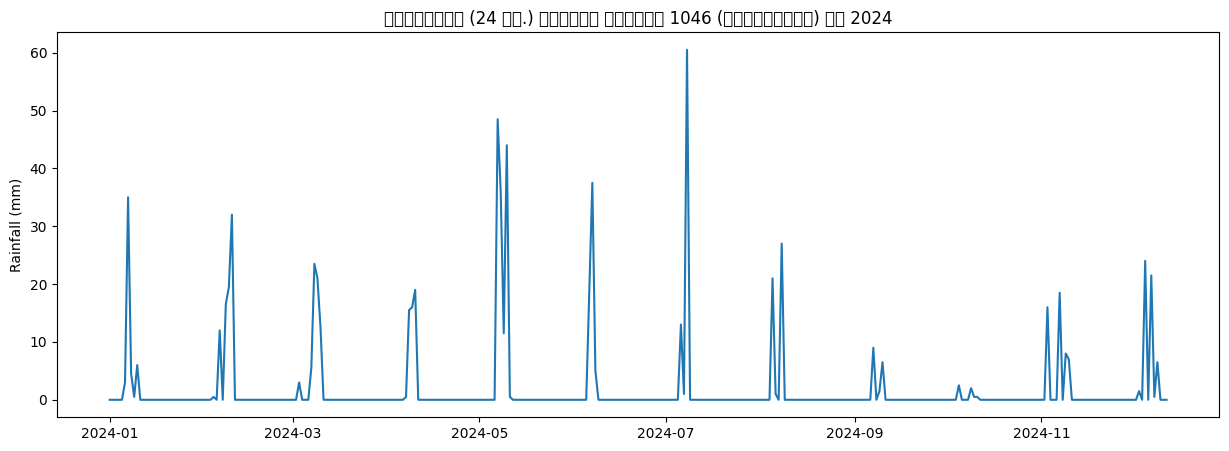

            rainfall_mm  season
date                           
2024-01-01          0.0  Winter
2024-01-02          0.0  Winter
2024-01-03          0.0  Winter
2024-01-04          0.0  Winter
2024-01-05          0.0  Winter
--------------------------------------------------


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---
# ขั้นที่ 1: โหลดข้อมูล (ไฟล์ Input เดียวกับ 06)
# ---

print("ขั้นที่ 1: กำลังโหลดข้อมูล...")
RAIN_DATA_PATH = "../data/PROCESSED/rain_2024_with_seasons.csv"
df_rain_raw = pd.read_csv(RAIN_DATA_PATH)

# ---
# ขั้นที่ 2: เตรียมข้อมูล (เหมือนใน 06)
# ---
print("ขั้นที่ 2: กำลังเตรียมข้อมูล...")

# 2.1 ระบุชื่อคอลัมน์ที่แท้จริง
ACTUAL_DATE_COLUMN = 'date_object'
ACTUAL_DCODE_COLUMN = 'dcode'
RAIN_COLUMN_TO_USE = 'ฝน 24 ชม.'

# 2.2 แปลงคอลัมน์ date ให้เป็น datetime object
df_rain_raw[ACTUAL_DATE_COLUMN] = pd.to_datetime(df_rain_raw[ACTUAL_DATE_COLUMN])

# 2.3 (สำคัญ!) เปลี่ยนชื่อคอลัมน์เพื่อให้เรียกใช้งานง่าย
df_rain_raw = df_rain_raw.rename(columns={
    ACTUAL_DATE_COLUMN: 'date',
    ACTUAL_DCODE_COLUMN: 'district_code',
    RAIN_COLUMN_TO_USE: 'rainfall_mm'
})

# 2.4 เลือกเฉพาะคอลัมน์ที่จำเป็นสำหรับ '07'
df_data = df_rain_raw[['date', 'district_code', 'rainfall_mm', 'season']].copy()

print("เตรียมข้อมูลสำเร็จ")
print(df_data.head())
print("-" * 50)


# ---
# ขั้นที่ 3: เลือก 1 เขตมาทดลอง (Focus)
# ---
print("ขั้นที่ 3: เลือก 1 เขต (จาก Cluster 0) มาสร้างโมเดลตัวอย่าง...")

# จากผลลัพธ์ 06 เรารู้ว่า 'เขตคลองสามวา' (dcode 1046) อยู่ใน Cluster 0
# เราจะสร้างโมเดลพยากรณ์สำหรับเขตนี้เป็นเขตแรก
DISTRICT_TO_FORECAST = '1046' 

df_district = df_data[df_data['district_code'] == int(DISTRICT_TO_FORECAST)].copy()

# (สำคัญ) ต้องตั้ง 'date' เป็น Index เพื่อทำงาน Time-Series
df_district = df_district.sort_values(by='date').set_index('date')

# (สำคัญ) ข้อมูลฝนอาจจะมีหลายสถานีในเขตเดียว เราต้องรวมเป็น 1 ค่าต่อวัน
# เราจะใช้ค่าเฉลี่ย (mean) ของทุกสถานีในเขตนั้น
df_ts = df_district.resample('D').agg({
    'rainfall_mm': 'mean',
    'season': 'first' # ฤดูจะเหมือนกันทั้งวันอยู่แล้ว
})

# เติมค่าว่าง (วันที่ไม่มีข้อมูล) ด้วย 0 (ฝนไม่ตก)
df_ts['rainfall_mm'] = df_ts['rainfall_mm'].fillna(0)
df_ts['season'] = df_ts['season'].ffill().bfill() # เติมค่าว่างของ season

print(f"ได้ข้อมูล Time-Series ของเขต {DISTRICT_TO_FORECAST} มา {df_ts.shape[0]} วัน")

# 4. พล็อตกราฟดูข้อมูลฝนของเขตนี้
plt.figure(figsize=(15, 5))
plt.plot(df_ts.index, df_ts['rainfall_mm'])
plt.title(f'ปริมาณฝน (24 ชม.) รายวัน ของเขต {DISTRICT_TO_FORECAST} (คลองสามวา) ปี 2024')
plt.ylabel('Rainfall (mm)')
plt.show()

print(df_ts.head())
print("-" * 50)

ขั้นที่ 4: กำลังสร้าง Feature พยากรณ์...


/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3649 (\N{THAI CHARACTER SARA AE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3618 (\N{THA

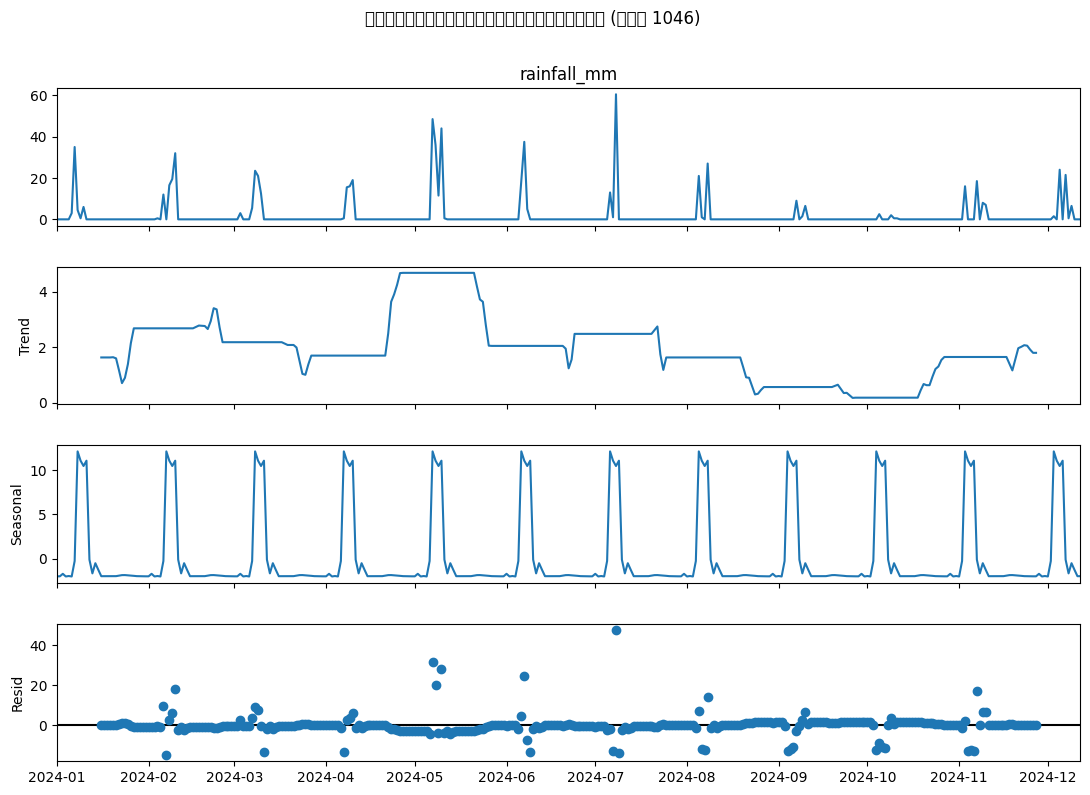

สร้าง Feature สำเร็จ ข้อมูลที่พร้อมเทรนมี 339 แถว
            rainfall_mm  rainfall_target  lag_1d  lag_2d  lag_3d  lag_4d  \
date                                                                       
2024-01-08          4.5              0.5    35.0     3.0     0.0     0.0   
2024-01-09          0.5              6.0     4.5    35.0     3.0     0.0   
2024-01-10          6.0              0.0     0.5     4.5    35.0     3.0   
2024-01-11          0.0              0.0     6.0     0.5     4.5    35.0   
2024-01-12          0.0              0.0     0.0     6.0     0.5     4.5   

            lag_5d  lag_6d  lag_7d  rolling_mean_7d  rolling_sum_3d  month  \
date                                                                         
2024-01-08     0.0     0.0     0.0         5.428571            38.0      1   
2024-01-09     0.0     0.0     0.0         6.071429            42.5      1   
2024-01-10     0.0     0.0     0.0         6.142857            40.0      1   
2024-01-11     3.0     0.0 

In [5]:
# ---
# ขั้นที่ 4: สร้าง Feature พยากรณ์ (Feature Engineering)
# ---
print("ขั้นที่ 4: กำลังสร้าง Feature พยากรณ์...")

# 4.1 (Optional) ลองแยกส่วนประกอบข้อมูล (Trend, Seasonality, Residual)
# เราจะใช้ period=30 วัน เพื่อดูแนวโน้มรายเดือน
decomposition = seasonal_decompose(df_ts['rainfall_mm'], model='additive', period=30)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('การแยกส่วนประกอบข้อมูลฝน (เขต 1046)', y=1.02)
plt.show()


# 4.2 สร้าง Target (y)
# นี่คือสิ่งที่เราต้องการทำนาย: "ฝนในวันพรุ่งนี้"
# เราใช้ .shift(-1) เพื่อดึงค่าของวันพรุ่งนี้ มาไว้ที่แถวของวันนี้
df_ts['rainfall_target'] = df_ts['rainfall_mm'].shift(-1)


# 4.3 สร้าง Lag Features (X)
# นี่คือข้อมูลในอดีตที่โมเดลจะใช้เรียนรู้: "ฝนเมื่อวานนี้เป็นยังไง?"
# เราจะสร้างข้อมูลย้อนหลัง 7 วัน (Lag 1-7)
for i in range(1, 8):
    df_ts[f'lag_{i}d'] = df_ts['rainfall_mm'].shift(i)

# 4.4 สร้าง Window Features (X)
# "ค่าเฉลี่ยฝน 7 วันที่ผ่านมาเป็นยังไง?"
df_ts['rolling_mean_7d'] = df_ts['rainfall_mm'].shift(1).rolling(window=7).mean()
# "ผลรวมฝน 3 วันที่ผ่านมาเป็นยังไง?"
df_ts['rolling_sum_3d'] = df_ts['rainfall_mm'].shift(1).rolling(window=3).sum()


# 4.5 สร้าง Date Features (X)
df_ts['month'] = df_ts.index.month
df_ts['day_of_week'] = df_ts.index.dayofweek


# 4.6 สร้าง Categorical Features (X)
# แปลง 'season' ให้เป็นตัวเลข (One-Hot Encoding)
df_ts = pd.get_dummies(df_ts, columns=['season'], drop_first=True)


# 4.7 ทำความสะอาดข้อมูล
# เราจะลบแถวที่มีค่า NaN ออก
# (เช่น 7 วันแรก ที่ยังไม่มี 'lag_7d' หรือ 'rolling_mean_7d')
# (และวันสุดท้าย ที่ไม่มี 'rainfall_target')
df_model_data = df_ts.dropna()

print(f"สร้าง Feature สำเร็จ ข้อมูลที่พร้อมเทรนมี {df_model_data.shape[0]} แถว")
print(df_model_data.head())
print("-" * 50)


# ---
# ขั้นที่ 5: แบ่งข้อมูลสำหรับ Train/Test (เคารพเวลา)
# ---
print("ขั้นที่ 5: กำลังแบ่งข้อมูล Train/Test...")

# เราจะใช้ข้อมูล 80% แรกในการเทรน และ 20% สุดท้ายในการทดสอบ
# (นี่คือการแบ่งข้อมูล Time-Series ที่ถูกต้อง ห้ามสุ่ม!)
split_point = int(len(df_model_data) * 0.8)
df_train = df_model_data.iloc[:split_point]
df_test = df_model_data.iloc[split_point:]

# 5.1 กำหนด Features (X) และ Target (y)
FEATURES = [
    'lag_1d', 'lag_2d', 'lag_3d', 'lag_4d', 'lag_5d', 'lag_6d', 'lag_7d',
    'rolling_mean_7d', 'rolling_sum_3d',
    'month', 'day_of_week',
    'season_Summer', 'season_Winter' # มาจาก pd.get_dummies
]

TARGET = 'rainfall_target'

X_train = df_train[FEATURES]
y_train = df_train[TARGET]
X_test = df_test[FEATURES]
y_test = df_test[TARGET]

print(f"แบ่งข้อมูลสำเร็จ:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("-" * 50)

ขั้นที่ 6: กำลังเทรนโมเดล RandomForestRegressor...
เทรนโมเดลสำเร็จ!
--------------------------------------------------
ผลการประเมินโมเดล (เขต 1046):
Root Mean Squared Error (RMSE): 4.90 mm
Mean Absolute Error (MAE): 2.63 mm
ค่าฝนเฉลี่ย (Mean Rainfall) ในชุด Test: 1.57 mm
--------------------------------------------------


/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3612 (\N{THAI CHARACTER PHO PHUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3621 (\N{THAI CHARACTER LO LING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3619 (\N{

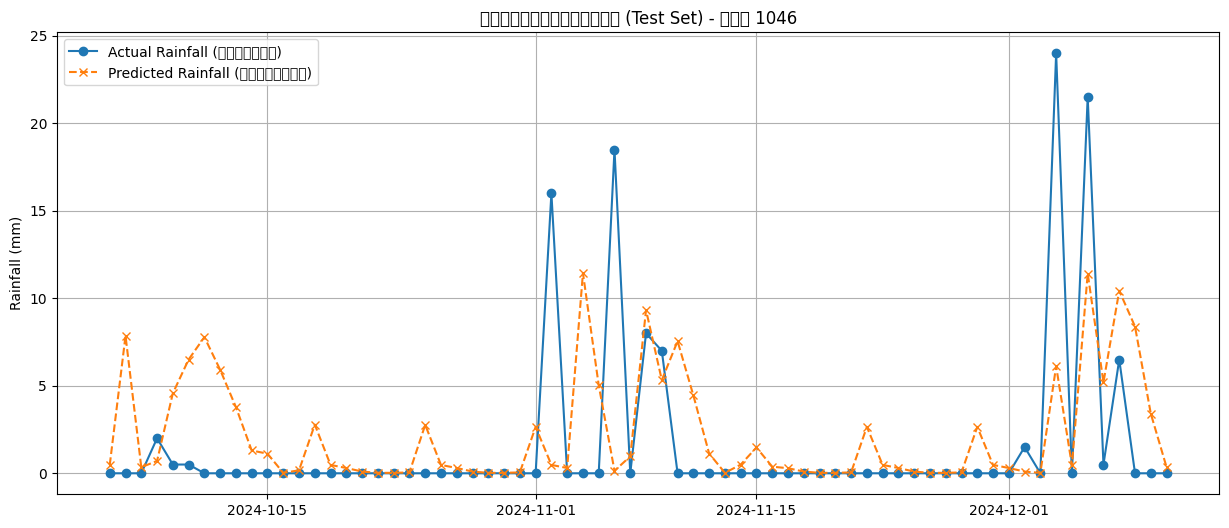

In [6]:
# ---
# ขั้นที่ 6: เทรนโมเดลและวัดผล
# ---
print("ขั้นที่ 6: กำลังเทรนโมเดล RandomForestRegressor...")

# 6.1 สร้างและเทรนโมเดล
# n_estimators=100 คือการสร้างป่าที่มีต้นไม้ 100 ต้น
# random_state=42 เพื่อให้ผลลัพธ์คงที่ทุกครั้งที่รัน
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print("เทรนโมเดลสำเร็จ!")

# 6.2 ทำนายข้อมูล Test
y_pred = model.predict(X_test)

# 6.3 ประเมินผลโมเดล
# RMSE (Root Mean Squared Error): ค่าเฉลี่ยความผิดพลาด (ยิ่งน้อยยิ่งดี)
# MAE (Mean Absolute Error): ค่าเฉลี่ยความผิดพลาด (แบบไม่ยกกำลังสอง)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("-" * 50)
print(f"ผลการประเมินโมเดล (เขต {DISTRICT_TO_FORECAST}):")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} mm")
print(f"Mean Absolute Error (MAE): {mae:.2f} mm")
print(f"ค่าฝนเฉลี่ย (Mean Rainfall) ในชุด Test: {y_test.mean():.2f} mm")
print("-" * 50)

# 6.4 (สำคัญที่สุด) พล็อตกราฟเทียบ "ค่าจริง" vs "ค่าที่ทำนายได้"
# เราจะสร้าง DataFrame ใหม่เพื่อพล็อตกราฟเทียบกันง่ายๆ
df_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

plt.figure(figsize=(15, 6))
plt.plot(df_results.index, df_results['Actual'], label='Actual Rainfall (ค่าจริง)', marker='o', linestyle='-')
plt.plot(df_results.index, df_results['Predicted'], label='Predicted Rainfall (ค่าทำนาย)', marker='x', linestyle='--')
plt.title(f'ผลการพยากรณ์ฝน (Test Set) - เขต {DISTRICT_TO_FORECAST}')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# --- (เพิ่ม Library ที่จำเป็นสำหรับ v2) ---
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# (นี่คือ 3 โมเดลที่เราจะเทียบกัน)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# ---
# ขั้นที่ 1: โหลดข้อมูล (เหมือนเดิม)
# ---
print("ขั้นที่ 1: กำลังโหลดข้อมูล...")
RAIN_DATA_PATH = "../data/PROCESSED/rain_2024_with_seasons.csv"
df_rain_raw = pd.read_csv(RAIN_DATA_PATH)

# ---
# ขั้นที่ 2: เตรียมข้อมูล (เหมือนเดิม)
# ---
print("ขั้นที่ 2: กำลังเตรียมข้อมูล...")
ACTUAL_DATE_COLUMN = 'date_object'
ACTUAL_DCODE_COLUMN = 'dcode'
RAIN_COLUMN_TO_USE = 'ฝน 24 ชม.'
df_rain_raw[ACTUAL_DATE_COLUMN] = pd.to_datetime(df_rain_raw[ACTUAL_DATE_COLUMN])
df_rain_raw = df_rain_raw.rename(columns={
    ACTUAL_DATE_COLUMN: 'date',
    ACTUAL_DCODE_COLUMN: 'district_code',
    RAIN_COLUMN_TO_USE: 'rainfall_mm'
})
df_data = df_rain_raw[['date', 'district_code', 'rainfall_mm', 'season']].copy()
print("เตรียมข้อมูลสำเร็จ")
print("-" * 50)

# ---
# ขั้นที่ 3: เลือก 1 เขตมาทดลอง (เหมือนเดิม)
# ---
print("ขั้นที่ 3: เลือก 1 เขต (จาก Cluster 0) มาสร้างโมเดลตัวอย่าง...")
DISTRICT_TO_FORECAST = '1046' # เขตคลองสามวา
df_district = df_data[df_data['district_code'] == int(DISTRICT_TO_FORECAST)].copy()
df_district = df_district.sort_values(by='date').set_index('date')
df_ts = df_district.resample('D').agg({
    'rainfall_mm': 'mean',
    'season': 'first'
})
df_ts['rainfall_mm'] = df_ts['rainfall_mm'].fillna(0)
df_ts['season'] = df_ts['season'].ffill().bfill()
print(f"ได้ข้อมูล Time-Series ของเขต {DISTRICT_TO_FORECAST} มา {df_ts.shape[0]} วัน")
print("-" * 50)


# ---
# ขั้นที่ 4: สร้าง Feature พยากรณ์ (v2 - Classification)
# ---
print("ขั้นที่ 4: กำลังสร้าง Feature พยากรณ์ (v2 - Classification)...")

# 4.1 (สำคัญ!) กำหนดเกณฑ์ "ฝนหนัก"
# เราจะกำหนดว่า "ฝนหนัก" (y=1) คือวันที่ฝนตกเกิน 10 มม.
# คุณสามารถเปลี่ยนเลขนี้ได้ (เช่น 15, 20) ถ้าอยากให้โมเดลเน้นจับฝนที่หนักขึ้น
HEAVY_RAIN_THRESHOLD = 5.0 
print(f"กำหนดเกณฑ์ 'ฝนหนัก' (y=1) คือ > {HEAVY_RAIN_THRESHOLD} mm")

# 4.2 สร้าง Target (y)
# 'target_heavy_rain' (1 ถ้าพรุ่งนี้ฝนตกหนัก, 0 ถ้าไม่)
df_ts['target_heavy_rain'] = (df_ts['rainfall_mm'].shift(-1) > HEAVY_RAIN_THRESHOLD).astype(int)


# 4.3 สร้าง Lag Features (X) (เหมือนเดิม)
for i in range(1, 8):
    df_ts[f'lag_{i}d'] = df_ts['rainfall_mm'].shift(i)

# 4.4 สร้าง Window Features (X) (เหมือนเดิม)
df_ts['rolling_mean_7d'] = df_ts['rainfall_mm'].shift(1).rolling(window=7).mean()
df_ts['rolling_sum_3d'] = df_ts['rainfall_mm'].shift(1).rolling(window=3).sum()

# 4.5 สร้าง Date Features (X) (เหมือนเดิม)
df_ts['month'] = df_ts.index.month
df_ts['day_of_week'] = df_ts.index.dayofweek

# 4.6 สร้าง Categorical Features (X) (เหมือนเดิม)
df_ts = pd.get_dummies(df_ts, columns=['season'], drop_first=True)

# 4.7 ทำความสะอาดข้อมูล
df_model_data = df_ts.dropna()

print(f"สร้าง Feature สำเร็จ ข้อมูลที่พร้อมเทรนมี {df_model_data.shape[0]} แถว")
print("-" * 50)


# ---
# ขั้นที่ 5: แบ่งข้อมูลสำหรับ Train/Test (v2 - Classification)
# ---
print("ขั้นที่ 5: กำลังแบ่งข้อมูล Train/Test...")

split_point = int(len(df_model_data) * 0.8)
df_train = df_model_data.iloc[:split_point]
df_test = df_model_data.iloc[split_point:]

# 5.1 กำหนด Features (X) และ Target (y)
FEATURES = [
    'lag_1d', 'lag_2d', 'lag_3d', 'lag_4d', 'lag_5d', 'lag_6d', 'lag_7d',
    'rolling_mean_7d', 'rolling_sum_3d',
    'month', 'day_of_week',
    'season_Summer', 'season_Winter'
]
TARGET = 'target_heavy_rain' # <--- เปลี่ยน Target ใหม่

X_train = df_train[FEATURES]
y_train = df_train[TARGET]
X_test = df_test[FEATURES]
y_test = df_test[TARGET]

# 5.2 (สำคัญ!) ตรวจสอบความไม่สมดุลของข้อมูล
print("ตรวจสอบความไม่สมดุลของข้อมูล (Train Set):")
print(y_train.value_counts())
# (เราจะเห็นว่า 0 (ไม่หนัก) เยอะกว่า 1 (หนัก) มาก -> นี่คือปัญหา Imbalance)

print(f"แบ่งข้อมูลสำเร็จ:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("-" * 50)


# ---
# ขั้นที่ 6 & 7: เทรนและเปรียบเทียบ 3 โมเดล
# ---

# (เราจะใช้ class_weight='balanced' เพื่อ"บังคับ"ให้โมเดลสนใจ class 1 ที่มีน้อย)
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Hist. Gradient Boosting": HistGradientBoostingClassifier(random_state=42, class_weight='balanced')
}

# วนลูปเทรนและประเมินผลทีละโมเดล
for name, model in models.items():
    print(f"==================================================")
    print(f"กำลังเทรนโมเดล: {name}")
    print(f"==================================================")
    
    # เทรนโมเดล
    model.fit(X_train, y_train)
    
    # ทำนาย
    y_pred = model.predict(X_test)
    
    # พิมพ์ Classification Report (นี่คือหัวใจของการเปรียบเทียบ)
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred, target_names=['Not Heavy (0)', 'Heavy Rain (1)']))
    
    # พิมพ์ Confusion Matrix
    print("\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_pred)
    # (แถวคือ 'Actual', คอลัมน์คือ 'Predicted')
    print(f"True Neg (ทาย 0 ถูก): {cm[0][0]} | False Pos (ทาย 1 ผิด): {cm[0][1]}")
    print(f"False Neg (ทาย 0 ผิด): {cm[1][0]} | True Pos (ทาย 1 ถูก): {cm[1][1]}")
    print("\n")

print("--- จบการเปรียบเทียบ ---")

ขั้นที่ 1: กำลังโหลดข้อมูล...
ขั้นที่ 2: กำลังเตรียมข้อมูล...
เตรียมข้อมูลสำเร็จ
--------------------------------------------------
ขั้นที่ 3: เลือก 1 เขต (จาก Cluster 0) มาสร้างโมเดลตัวอย่าง...
ได้ข้อมูล Time-Series ของเขต 1046 มา 347 วัน
--------------------------------------------------
ขั้นที่ 4: กำลังสร้าง Feature พยากรณ์ (v2 - Classification)...
กำหนดเกณฑ์ 'ฝนหนัก' (y=1) คือ > 5.0 mm
สร้าง Feature สำเร็จ ข้อมูลที่พร้อมเทรนมี 340 แถว
--------------------------------------------------
ขั้นที่ 5: กำลังแบ่งข้อมูล Train/Test...
ตรวจสอบความไม่สมดุลของข้อมูล (Train Set):
target_heavy_rain
0    248
1     24
Name: count, dtype: int64
แบ่งข้อมูลสำเร็จ:
X_train shape: (272, 13)
X_test shape: (68, 13)
--------------------------------------------------
กำลังเทรนโมเดล: Logistic Regression

Classification Report (Test Set):
                precision    recall  f1-score   support

 Not Heavy (0)       0.91      0.95      0.93        61
Heavy Rain (1)       0.25      0.14      0.18         7

   

/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/flood_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is


Classification Report (Test Set):
                precision    recall  f1-score   support

 Not Heavy (0)       0.92      0.79      0.85        61
Heavy Rain (1)       0.19      0.43      0.26         7

      accuracy                           0.75        68
     macro avg       0.56      0.61      0.56        68
  weighted avg       0.85      0.75      0.79        68


Confusion Matrix (Test Set):
True Neg (ทาย 0 ถูก): 48 | False Pos (ทาย 1 ผิด): 13
False Neg (ทาย 0 ผิด): 4 | True Pos (ทาย 1 ถูก): 3


--- จบการเปรียบเทียบ ---


In [9]:
import sys
!{sys.executable} -m pip install imbalanced-learn

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# --- (เพิ่ม Library ที่จำเป็นสำหรับ v3) ---
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# (นี่คือ Library ใหม่สำหรับ SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # (สำคัญ: ต้องใช้ Pipeline พิเศษ)

# ---
# ขั้นที่ 1-3 (เหมือนเดิมทุกประการ)
# ---
print("ขั้นที่ 1-3: (กำลังโหลดและเตรียมข้อมูล...)")
RAIN_DATA_PATH = "../data/PROCESSED/rain_2024_with_seasons.csv"
df_rain_raw = pd.read_csv(RAIN_DATA_PATH)
ACTUAL_DATE_COLUMN = 'date_object'
ACTUAL_DCODE_COLUMN = 'dcode'
RAIN_COLUMN_TO_USE = 'ฝน 24 ชม.'
df_rain_raw[ACTUAL_DATE_COLUMN] = pd.to_datetime(df_rain_raw[ACTUAL_DATE_COLUMN])
df_rain_raw = df_rain_raw.rename(columns={
    ACTUAL_DATE_COLUMN: 'date',
    ACTUAL_DCODE_COLUMN: 'district_code',
    RAIN_COLUMN_TO_USE: 'rainfall_mm'
})
df_data = df_rain_raw[['date', 'district_code', 'rainfall_mm', 'season']].copy()
DISTRICT_TO_FORECAST = '1046'
df_district = df_data[df_data['district_code'] == int(DISTRICT_TO_FORECAST)].copy()
df_district = df_district.sort_values(by='date').set_index('date')
df_ts = df_district.resample('D').agg({
    'rainfall_mm': 'mean',
    'season': 'first'
})
df_ts['rainfall_mm'] = df_ts['rainfall_mm'].fillna(0)
df_ts['season'] = df_ts['season'].ffill().bfill()
print("...โหลดข้อมูลสำเร็จ")
print("-" * 50)

# ---
# ขั้นที่ 4: สร้าง Feature พยากรณ์ (v3 - Threshold 5.0 mm)
# ---
print("ขั้นที่ 4: กำลังสร้าง Feature พยากรณ์ (v3 - Threshold 5.0 mm)...")
HEAVY_RAIN_THRESHOLD = 5.0 # (เราใช้ 5.0 mm ที่เวิร์คที่สุด)
print(f"กำหนดเกณฑ์ 'ฝนหนัก' (y=1) คือ > {HEAVY_RAIN_THRESHOLD} mm")

df_ts['target_heavy_rain'] = (df_ts['rainfall_mm'].shift(-1) > HEAVY_RAIN_THRESHOLD).astype(int)
for i in range(1, 8):
    df_ts[f'lag_{i}d'] = df_ts['rainfall_mm'].shift(i)
df_ts['rolling_mean_7d'] = df_ts['rainfall_mm'].shift(1).rolling(window=7).mean()
df_ts['rolling_sum_3d'] = df_ts['rainfall_mm'].shift(1).rolling(window=3).sum()
df_ts['month'] = df_ts.index.month
df_ts['day_of_week'] = df_ts.index.dayofweek
df_ts = pd.get_dummies(df_ts, columns=['season'], drop_first=True)
df_model_data = df_ts.dropna()
print(f"สร้าง Feature สำเร็จ ข้อมูลที่พร้อมเทรนมี {df_model_data.shape[0]} แถว")
print("-" * 50)

# ---
# ขั้นที่ 5: แบ่งข้อมูลสำหรับ Train/Test (เหมือนเดิม)
# ---
print("ขั้นที่ 5: กำลังแบ่งข้อมูล Train/Test...")
split_point = int(len(df_model_data) * 0.8)
df_train = df_model_data.iloc[:split_point]
df_test = df_model_data.iloc[split_point:]
FEATURES = [
    'lag_1d', 'lag_2d', 'lag_3d', 'lag_4d', 'lag_5d', 'lag_6d', 'lag_7d',
    'rolling_mean_7d', 'rolling_sum_3d',
    'month', 'day_of_week',
    'season_Summer', 'season_Winter'
]
TARGET = 'target_heavy_rain'
X_train = df_train[FEATURES]
y_train = df_train[TARGET]
X_test = df_test[FEATURES]
y_test = df_test[TARGET]
print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")
print("-" * 50)


# ---
# ขั้นที่ 6 & 7: เทรนและเปรียบเทียบ 3 โมเดล (v3 - เพิ่ม SMOTE)
# ---

# (เราจะเอา class_weight='balanced' ออก เพราะ SMOTE จะจัดการเรื่องนี้ให้เรา)
models_smote = {
    "Logistic Regression (SMOTE)": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    "Random Forest (SMOTE)": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', RandomForestClassifier(random_state=42))
    ]),
    "Hist. Gradient Boosting (SMOTE)": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', HistGradientBoostingClassifier(random_state=42))
    ])
}

# วนลูปเทรนและประเมินผลทีละโมเดล
for name, pipeline in models_smote.items():
    print(f"==================================================")
    print(f"กำลังเทรนโมเดล: {name}")
    print(f"==================================================")
    
    # เทรน Pipeline (SMOTE จะถูกใช้กับ X_train, y_train อัตโนมัติ)
    pipeline.fit(X_train, y_train)
    
    # ทำนาย (SMOTE จะไม่ถูกใช้กับ X_test)
    y_pred = pipeline.predict(X_test)
    
    # พิมพ์ Classification Report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred, target_names=['Not Heavy (0)', 'Heavy Rain (1)']))
    
    # พิมพ์ Confusion Matrix
    print("\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_pred)
    print(f"True Neg (ทาย 0 ถูก): {cm[0][0]} | False Pos (ทาย 1 ผิด): {cm[0][1]}")
    print(f"False Neg (ทาย 0 ผิด): {cm[1][0]} | True Pos (ทาย 1 ถูก): {cm[1][1]}")
    print("\n")

print("--- จบการเปรียบเทียบ (SMOTE) ---")

ขั้นที่ 1-3: (กำลังโหลดและเตรียมข้อมูล...)
...โหลดข้อมูลสำเร็จ
--------------------------------------------------
ขั้นที่ 4: กำลังสร้าง Feature พยากรณ์ (v3 - Threshold 5.0 mm)...
กำหนดเกณฑ์ 'ฝนหนัก' (y=1) คือ > 5.0 mm
สร้าง Feature สำเร็จ ข้อมูลที่พร้อมเทรนมี 340 แถว
--------------------------------------------------
ขั้นที่ 5: กำลังแบ่งข้อมูล Train/Test...
X_train shape: (272, 13) | X_test shape: (68, 13)
--------------------------------------------------
กำลังเทรนโมเดล: Logistic Regression (SMOTE)

Classification Report (Test Set):
                precision    recall  f1-score   support

 Not Heavy (0)       0.93      0.62      0.75        61
Heavy Rain (1)       0.15      0.57      0.24         7

      accuracy                           0.62        68
     macro avg       0.54      0.60      0.49        68
  weighted avg       0.85      0.62      0.69        68


Confusion Matrix (Test Set):
True Neg (ทาย 0 ถูก): 38 | False Pos (ทาย 1 ผิด): 23
False Neg (ทาย 0 ผิด): 3 | True Pos (ท